In [ ]:
import sys, os
from google.colab import drive

In [ ]:
#Mount Drive
drive.mount('/content/drive')
sys.path.insert(0,"/content/drive/My Drive/Test/MultilayerPerceptronFS/")
data_path= "/content/drive/My Drive/Test/MultilayerPerceptronFS/data/flowers"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import numpy as np
from tqdm.notebook import tqdm
from data.ImageLoader import getImages, convertToGrayscale, preprocessImage
from MLP.MLP import Dense, ActivationSoftmax, CategoricalCrossEntropyLoss, Backpropagation, ActivationReLU

In [ ]:
labels = ['Sunflower', 'Dandelion', 'Rose']
n_data = 100

X = None
y = None
for i in range(len(labels)):
    if(X is None):
        X = getImages(labels[i], n=n_data)
    else:
        X = np.append(X, getImages(labels[i], n=n_data), axis=0)

    if(y is None):
        y = np.full(shape=n_data,fill_value=i,dtype=np.int)
    else:
        y = np.append(y, np.full(shape=n_data,fill_value=i,dtype=np.int), axis=0)

print(X.shape)
X = convertToGrayscale(X)
print(X.shape)
X = preprocessImage(X)
print(X.shape)

(300, 240, 320, 3)
(300, 240, 320)
(300, 76800)


In [ ]:
# Change from sparse into one hot encoding
n_values = np.max(y) + 1
y = np.eye(n_values)[y]
print(y.shape)

(300, 3)


In [ ]:
# Change from sparse into one hot encoding
from sklearn.model_selection import train_test_split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42, stratify=y)

In [ ]:
# Probabilities in each class
print(y_train.sum(axis=0))
print(y_test.sum(axis=0))

[80. 80. 80.]
[20. 20. 20.]


In [ ]:
def accuracy(y_prob, y_true):
    return (prediction(y_prob) == np.argmax(y_true, axis=-1)).mean()

def prediction(y_prob):
    return np.argmax(y_prob, axis=-1)

# Dense Model

In [ ]:
class BinaryCrossEntropyLoss:
    def forward(self, y_pred, y_true):
        y_pred_clipped = np.clip(y_pred, 1e-7, 1 - 1e-7)
        sample_losses = -(y_true * np.log(y_pred_clipped) + (1 - y_true) * np.log(1 - y_pred_clipped))
        sample_losses = np.mean(sample_losses, axis=-1)

        # Return losses
        return sample_losses

    # Backward pass
    def backward(self, dvalues, y_true):
        samples = len(dvalues)
        outputs = len(dvalues[0])
        clipped_dvalues = np.clip(dvalues, 1e-7, 1 - 1e-7)

        self.dinputs = -(y_true / clipped_dvalues - (1 - y_true) / (1 - clipped_dvalues)) / outputs
        self.dinputs = self.dinputs / samples

In [ ]:
# Hyperparameter
batch_size = 5
learning_rate = 0.001
epochs = 50

In [ ]:
# Create Layer
# input shape = (600, 76800)
# output shape = (,3)

dense_0 = Dense(76800, 512)
activation0 = ActivationReLU()
dense_1 = Dense(512, 3)
activation1 = ActivationSoftmax()
CELoss = CategoricalCrossEntropyLoss()
backprop = Backpropagation(learning_rate)

In [ ]:
#Training
loss = []
acc = []

n_data = len(X_train)
n_batch = n_data//batch_size

remainder = n_data%batch_size
if(remainder!=0):
    n_batch += 1

for _ in tqdm(range(epochs), desc='Epochs'):
    batch_loss = []
    batch_acc = []

    for i in tqdm(range(n_batch), desc='Batches', leave=False):
        #if batch can not be equally divided
        #batch all of the remainder data
        if(i*batch_size+batch_size>n_data):
            x_batch = X_train[i*batch_size:]
            y_batch = y_train[i*batch_size:]
            print("remainder")
        else:
            x_batch = X_train[i*batch_size: (i+1) *batch_size]
            y_batch = y_train[i*batch_size: (i+1) *batch_size]

        #Forward pass
        dense_0.forward(x_batch)
        activation0.forward(dense_0.output)
        dense_1.forward(activation0.output)
        activation1.forward(dense_1.output)

        #Backward pass
        CELoss.backward(activation1.output, y_batch)
        dense_1.backward(CELoss.dinputs)
        activation0.backward(dense_1.dinputs)
        dense_0.backward(activation0.dinputs)

        #Update Weight
        backprop.updateParams(dense_1)
        backprop.updateParams(dense_0)

        #Calculate Metrics/ batch
        batch_acc.append(accuracy(activation1.output, y_batch))
        batch_loss.append(np.sum(CELoss.forward(activation1.output, y_batch))/batch_size)
        #print(activation1.output)
    
    #print(len(batch_loss))
    acc.append(np.mean(batch_acc))
    loss.append(np.mean(batch_loss))
    print("Accuracy:",acc[-1])
    print("Entropy Loss:",loss[-1])


Accuracy: 0.3541666666666667
Entropy Loss: 10.257011143489532


Accuracy: 0.3
Entropy Loss: 11.282666985670827


Accuracy: 0.29583333333333334
Entropy Loss: 11.349827488472494


Accuracy: 0.3333333333333333
Entropy Loss: 10.690066942680636


Accuracy: 0.3833333333333333
Entropy Loss: 9.828702178769397


Accuracy: 0.3
Entropy Loss: 11.249673960097917


Accuracy: 0.3416666666666666
Entropy Loss: 10.382368296422605


Accuracy: 0.37083333333333335
Entropy Loss: 9.627625865588927


Accuracy: 0.2916666666666667
Entropy Loss: 10.48616338332552


Accuracy: 0.43333333333333335
Entropy Loss: 7.527289606779095


Accuracy: 0.4000000000000001
Entropy Loss: 7.2206842613994295


Accuracy: 0.4166666666666667
Entropy Loss: 6.083467071527643


Accuracy: 0.44583333333333336
Entropy Loss: 4.852028632082603


Accuracy: 0.45
Entropy Loss: 3.819071745548873


Accuracy: 0.47500000000000003
Entropy Loss: 3.013608152837431


Accuracy: 0.4791666666666667
Entropy Loss: 2.121558371766069


Accuracy: 0.4875
Entropy Loss: 2.027482950178149


Accuracy: 0.4916666666666667
Entropy Loss: 1.8648485258664342


Accuracy: 0.5041666666666667
Entropy Loss: 1.7049716840629774


Accuracy: 0.5291666666666667
Entropy Loss: 1.5821733238579387


Accuracy: 0.5625
Entropy Loss: 1.4792365811454966


Accuracy: 0.5625
Entropy Loss: 1.3911450233869604


Accuracy: 0.5625
Entropy Loss: 1.3153034150442116


Accuracy: 0.5750000000000001
Entropy Loss: 1.248306332484698


Accuracy: 0.5791666666666667
Entropy Loss: 1.1906230404862885


Accuracy: 0.5916666666666667
Entropy Loss: 1.1400164468664717


Accuracy: 0.5916666666666667
Entropy Loss: 1.0951255019348023


Accuracy: 0.5916666666666667
Entropy Loss: 1.0528743915921293


Accuracy: 0.6
Entropy Loss: 1.0128919033967039


Accuracy: 0.6166666666666666
Entropy Loss: 0.9747464165391699


Accuracy: 0.6375
Entropy Loss: 0.9405053680832308


Accuracy: 0.6625
Entropy Loss: 0.9082528714689246


Accuracy: 0.6833333333333332
Entropy Loss: 0.8770159068931651


Accuracy: 0.6875
Entropy Loss: 0.8463602039466472


Accuracy: 0.7041666666666667
Entropy Loss: 0.8168870253935309


Accuracy: 0.7291666666666666
Entropy Loss: 0.786777827048355


Accuracy: 0.7374999999999999
Entropy Loss: 0.7556593397600732


Accuracy: 0.7541666666666665
Entropy Loss: 0.723466752350307


Accuracy: 0.7583333333333333
Entropy Loss: 0.6916673951486674


Accuracy: 0.7583333333333333
Entropy Loss: 0.6646441382675564


Accuracy: 0.7833333333333333
Entropy Loss: 0.6430983791722226


Accuracy: 0.775
Entropy Loss: 0.6207377095911369


Accuracy: 0.8041666666666666
Entropy Loss: 0.5933903226463445


Accuracy: 0.8125
Entropy Loss: 0.5686803706990897


Accuracy: 0.8166666666666668
Entropy Loss: 0.5459493672558009


Accuracy: 0.8208333333333333
Entropy Loss: 0.525018626439819


Accuracy: 0.8208333333333332
Entropy Loss: 0.5061133189910251


Accuracy: 0.8291666666666666
Entropy Loss: 0.4863332492952402


Accuracy: 0.8291666666666666
Entropy Loss: 0.4670572169479328


Accuracy: 0.8458333333333332
Entropy Loss: 0.4464407434735486



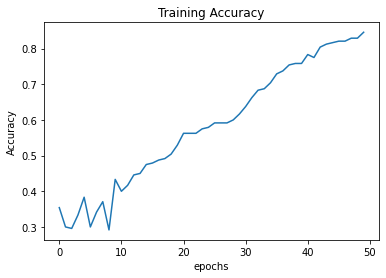

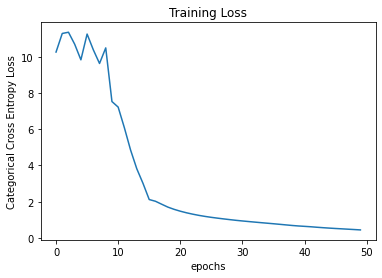

In [ ]:
import matplotlib.pyplot as plt
plt.plot(acc)
plt.title('Training Accuracy')
plt.xlabel('epochs')
plt.ylabel('Accuracy')
plt.show()
plt.plot(loss)
plt.title('Training Loss')
plt.xlabel('epochs')
plt.ylabel('Categorical Cross Entropy Loss')
plt.show()

In [ ]:
dense_0.forward(X_test)
activation0.forward(dense_0.output)
dense_1.forward(activation0.output)
activation1.forward(dense_1.output)

print(accuracy(activation1.output, y_test))

0.35


# CNN Model

In [ ]:
labels = ['Sunflower', 'Dandelion', 'Rose']
n_data = 100

X = None
y = None
for i in range(len(labels)):
    if(X is None):
        X = getImages(labels[i], n=n_data)
    else:
        X = np.append(X, getImages(labels[i], n=n_data), axis=0)

    if(y is None):
        y = np.full(shape=n_data,fill_value=i,dtype=np.int)
    else:
        y = np.append(y, np.full(shape=n_data,fill_value=i,dtype=np.int), axis=0)

In [ ]:
n_values = np.max(y) + 1
y = np.eye(n_values)[y]
print(y.shape)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42, stratify=y)

(300, 3)


In [ ]:
X_train.shape

(240, 240, 320, 3)

In [ ]:
import tensorflow as tf

In [ ]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Conv2D(16, (3, 3), activation='relu', input_shape=(240, 320, 3)))
model.add(tf.keras.layers.MaxPooling2D((2, 2)))
model.add(tf.keras.layers.Conv2D(32, (3, 3), activation='relu'))
model.add(tf.keras.layers.MaxPooling2D((2, 2)))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(64))
model.add(tf.keras.layers.Dense(32))
model.add(tf.keras.layers.Dense(3, activation='softmax'))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics='acc')
model.fit(X_train, y_train, batch_size=5, epochs=10, validation_data=(X_test, y_test))

Epoch 1/10
48/48 [==============================] - 11s 227ms/step - loss: 3553.1231 - acc: 0.4556 - val_loss: 67.9128 - val_acc: 0.6000
Epoch 2/10
48/48 [==============================] - 11s 224ms/step - loss: 13.3752 - acc: 0.8526 - val_loss: 38.3132 - val_acc: 0.5167
Epoch 3/10
48/48 [==============================] - 11s 224ms/step - loss: 2.9085 - acc: 0.9045 - val_loss: 33.2283 - val_acc: 0.5333
Epoch 4/10
48/48 [==============================] - 11s 223ms/step - loss: 0.3806 - acc: 0.9520 - val_loss: 38.9132 - val_acc: 0.5333
Epoch 5/10
48/48 [==============================] - 11s 223ms/step - loss: 0.0140 - acc: 0.9953 - val_loss: 38.8063 - val_acc: 0.5167
Epoch 6/10
48/48 [==============================] - 11s 224ms/step - loss: 0.0029 - acc: 1.0000 - val_loss: 38.7701 - val_acc: 0.5167
Epoch 7/10
48/48 [==============================] - 11s 224ms/step - loss: 0.0015 - acc: 1.0000 - val_loss: 38.7786 - val_acc: 0.5167
Epoch 8/10
48/48 [==============================] - 11s 22